# Import Start Libraries

In [139]:
import pandas as pd
from pandas import np
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels import api as sm
tsa = sm.tsa

from datetime import datetime
%matplotlib inline


# Import data as time series dataset

In [201]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('./CCI.csv', parse_dates=True, index_col='TIME',date_parser=dateparse)
df = df["Value"]
df.columns = ["value"]

# Visualize data

In [202]:
df.head()

TIME
1960-01-01    101.5840
1960-02-01    101.3255
1960-03-01    101.1023
1960-04-01    100.9791
1960-05-01    101.0102
Name: Value, dtype: float64

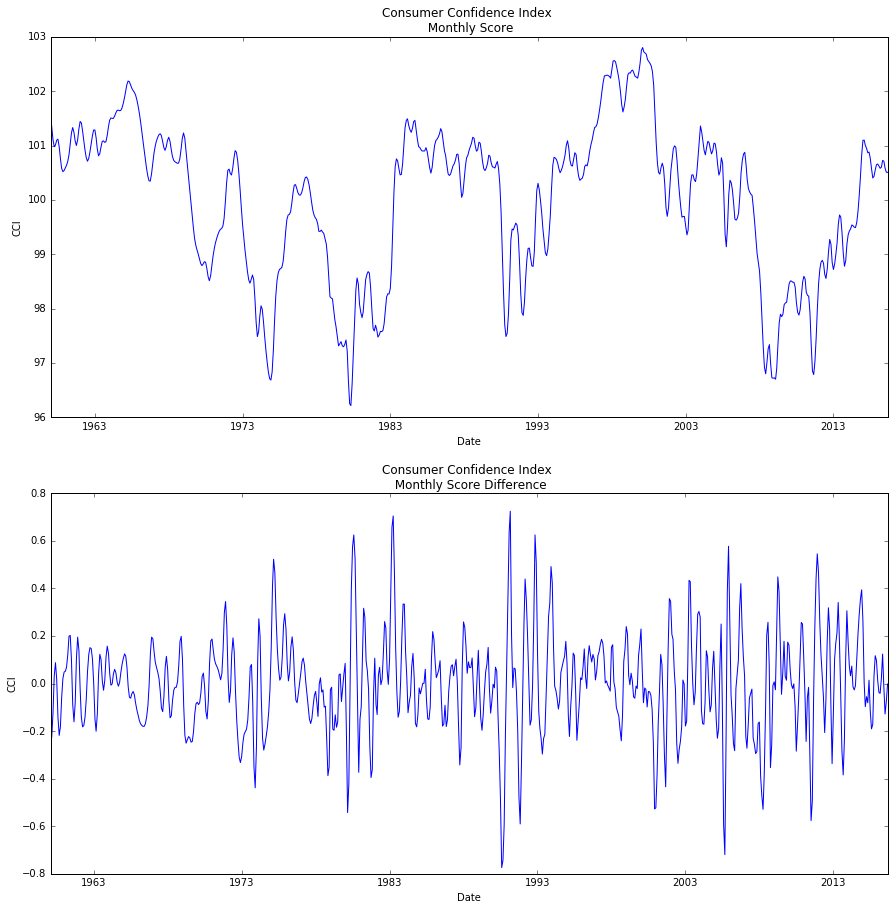

In [204]:
fig = plt.figure(figsize = (15, 15))

ax1 = fig.add_subplot(2, 1, 1)
ax1 = plt.plot(df)
ax1 = plt.title('Consumer Confidence Index \n Monthly Score')
ax1 = plt.xlabel('Date')
ax1 = plt.ylabel('CCI')

ax1 = fig.add_subplot(2, 1, 2)
ax1 = plt.plot(df.diff())
ax1 = plt.title('Consumer Confidence Index \n Monthly Score Difference')
ax1 = plt.xlabel('Date')
ax1 = plt.ylabel('CCI')

plt.show()

# Define and execute functions for testing stationary condition

In [157]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax = plt.plot(timeseries, color='blue',label='Original')
    ax = plt.plot(rolmean, color='red', label='Rolling Mean')
    #ax = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #ax = plt.plot(timeseries-rolmean, color='green', label = 'Noise')
    ax = plt.legend(loc='best')
    ax = plt.title('CCI and its Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    for j in ['nc', 'c', 'ct']:
        print ''
        print 'Results of Dickey-Fuller Test (Reg. {}):'.format(j)
        dftest = tsa.adfuller(timeseries, autolag='AIC', regression = j)
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print dfoutput

In [155]:
def is_unit_root(data, threshold="5%"):
    
    nc = tsa.adfuller(data, regression="nc")
    c = tsa.adfuller(data, regression="c")
    ct = tsa.adfuller(data, regression="ct")
    
    votes = 0
    for test in [nc, c, ct]:
        if(abs(test[0]) < abs(test[4][threshold])):
            votes += 1
            
    return votes >= 2, {"nc": nc, "c":c, "ct":ct}

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


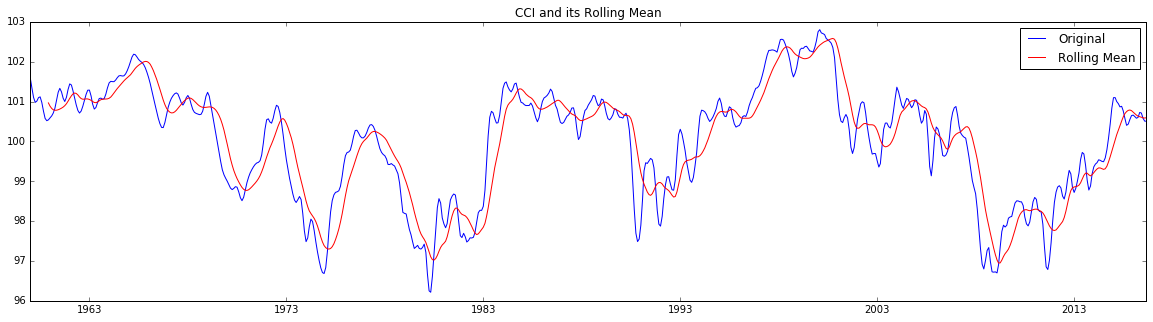


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                  -0.125184
p-value                          0.641107
#Lags Used                       4.000000
Number of Observations Used    676.000000
Critical Value (5%)             -1.941405
Critical Value (1%)             -2.569055
Critical Value (10%)            -1.616433
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                  -3.278088
p-value                          0.015887
#Lags Used                      14.000000
Number of Observations Used    666.000000
Critical Value (5%)             -2.865889
Critical Value (1%)             -3.440207
Critical Value (10%)            -2.569086
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                  -3.269212
p-value                          0.071471
#Lags Used                      14.000000
Number of Observations Used    666.000000
Critical Value (5%)             -3.417103
Critical Value (1%)             -3.972428
Criti

In [209]:
test_stationarity(df)

In [210]:
a, b = is_unit_root(df)
print 'At 5% Significance level, votes suggest that null hypothesis of I(1) is', a

At 5% Significance level, votes suggest that null hypothesis of I(1) is True


# Test stationary condition on the first difference of CCI

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


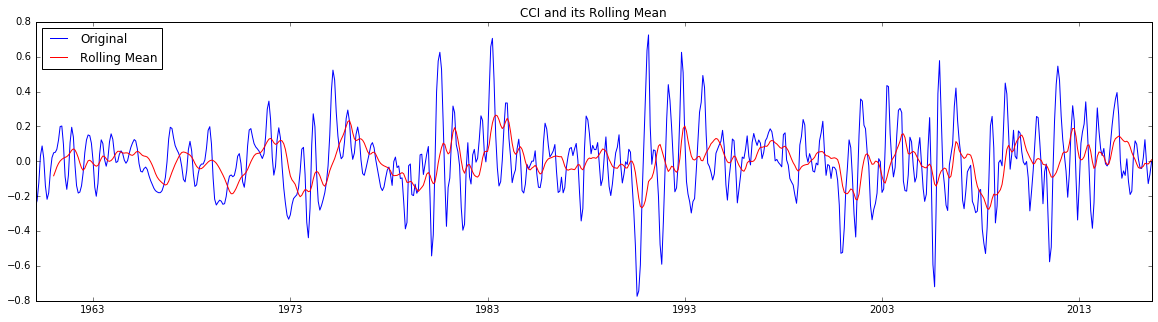


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                -1.176429e+01
p-value                        2.049708e-21
#Lags Used                     3.000000e+00
Number of Observations Used    6.760000e+02
Critical Value (5%)           -1.941405e+00
Critical Value (1%)           -2.569055e+00
Critical Value (10%)          -1.616433e+00
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                -1.175590e+01
p-value                        1.178898e-21
#Lags Used                     3.000000e+00
Number of Observations Used    6.760000e+02
Critical Value (5%)           -2.865825e+00
Critical Value (1%)           -3.440061e+00
Critical Value (10%)          -2.569052e+00
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                -1.175528e+01
p-value                        9.753881e-19
#Lags Used                     3.000000e+00
Number of Observations Used    6.760000e+02
Critical Value (5%)           -3.417005e+00
Critical 

In [212]:
diff = df.diff()
diff.dropna(inplace=True)
test_stationarity(diff)

In [213]:
a, b = is_unit_root(diff)
print 'At 5% Significance level, votes suggest that null hypothesis of I(1) is', a

At 5% Significance level, votes suggest that null hypothesis of I(1) is False


# Define parameters of the ARIMA model

In [214]:
from statsmodels.tsa.stattools import acf, pacf
diff_acf = acf(diff, nlags = 20)
diff_pacf = pacf(diff, nlags = 20, method = 'ols')

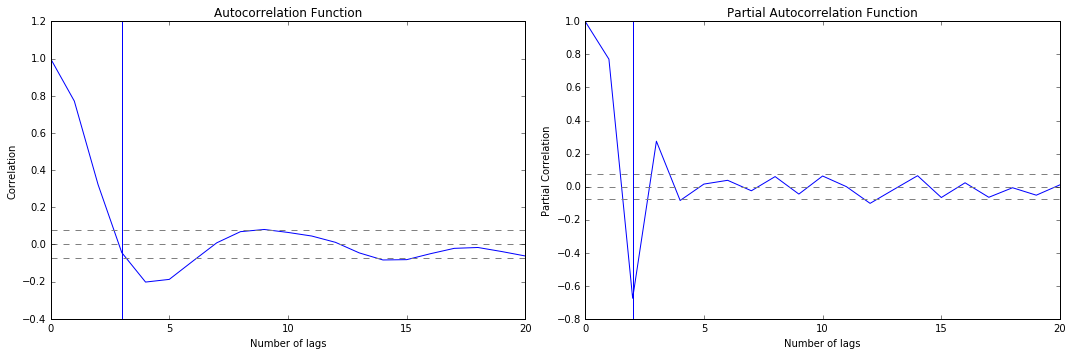

In [215]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(diff_acf)
plt.xlabel('Number of lags')
plt.ylabel('Correlation')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.axvline(3)

plt.subplot(122)
plt.plot(diff_pacf)
plt.xlabel('Number of lags')
plt.ylabel('Partial Correlation')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.axvline(2)

plt.tight_layout()
plt.show()

- We should pick as p (number of AR lags) the lag for which the upper boundary is first cut in the PACF.
- We should pick as q (number of MA lags) the lag for which the upper boundary is first cut in the ACF.
- For this ARIMA model, p = 2 and q = 3.

# Show AR (q = 0), MA (p = 0) and ARIMA (p, q != 0) models.

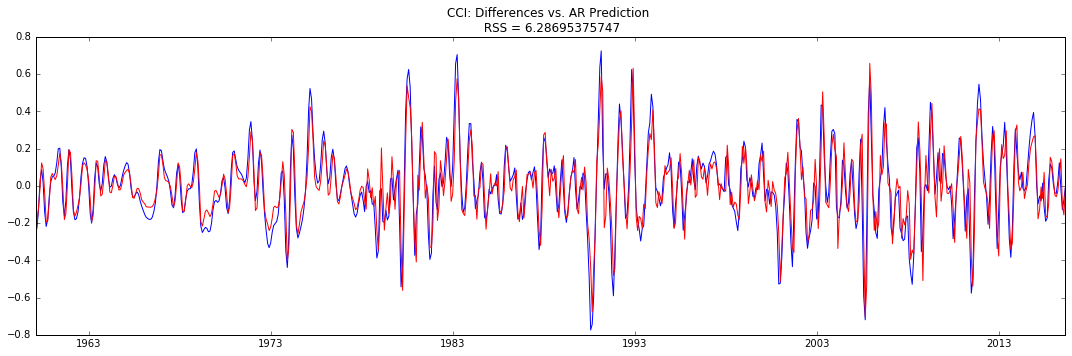

In [234]:
# AR Model
model_AR = tsa.ARIMA(df, order=(2, 1, 0))
results_AR = model_AR.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('CCI: Differences vs. AR Prediction \n RSS = {}'.format(sum((results_AR.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

In [248]:
# MA Model - 3 MA lags
model_MA = tsa.ARIMA(df, order=(0, 1, 3))
results_MA = model_MA.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('CCI: Differences vs. MA Prediction \n RSS = {}'.format(sum((results_MA.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

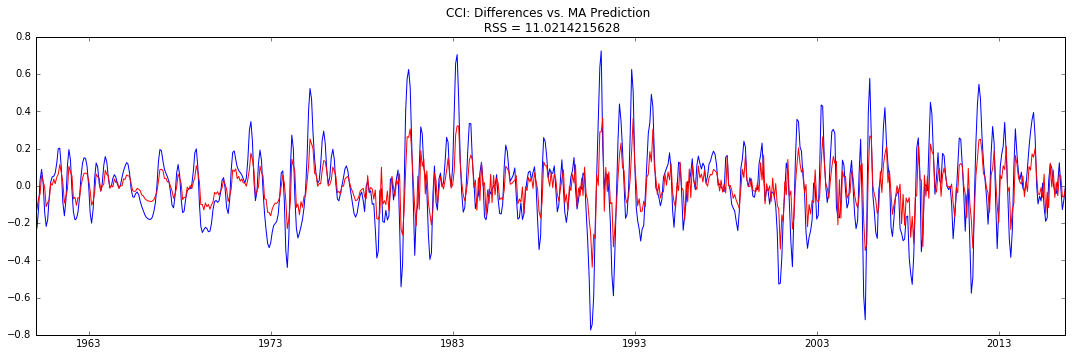

In [249]:
# MA Model - 1 MA lag
model_MA = tsa.ARIMA(df, order=(0, 1, 1))
results_MA = model_MA.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('CCI: Differences vs. MA Prediction \n RSS = {}'.format(sum((results_MA.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

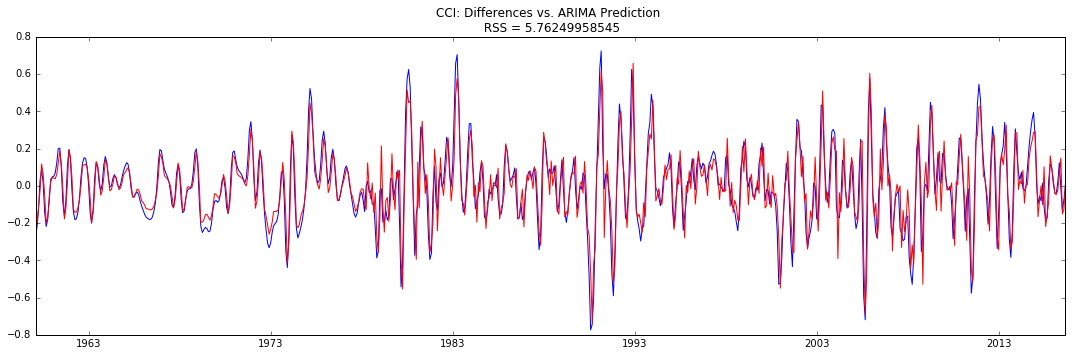

In [237]:
# ARIMA Model
model_ARIMA = tsa.ARIMA(df, order=(2, 1, 3))
results_ARIMA = model_ARIMA.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('CCI: Differences vs. ARIMA Prediction \n RSS = {}'.format(sum((results_ARIMA.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

- MA model does not work (Coefficients are not invertible) with the three MA lags suggested from the Autocorrelation function. It works, however, with one MA lag. 
- Best model is the ARIMA model, which incorporates both autoregressive (p=2) and moving average (q=1) regressors. 

In [282]:
results_ARIMA.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            Log-Likelihood:      659.11    
Dependent Variable: D.Value          Scale:               1.0000    
Date:               2016-11-28 12:50 Method:              css-mle   
No. Observations:   680              Sample:              02-01-1960
Df Model:           6                                     09-01-2016
Df Residuals:       674              S.D. of innovations: 0.092     
AIC:                -1304.2104       HQIC:                -1291.958 
BIC:                -1272.5557                                      
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            -0.0017    0.0117  -0.1464  0.8837  -0.0246   0.0212
ar.L1.D.Value     1.0785    0.1041  10.3579  0.0000   0.8744   1.2826
ar.L2.D.Value    -0.4832    0.0563  -8.5907  0.0000  -0.5935  -0.3730
ma.L1.D.Value     0.4300    0.1086   3.9593  0.0001   0.2171   0.6429
ma.L2.D.Value    -0.0031    0.1251  -0.0246  0.9804  -0.2483   0.2422
ma.L3.D.Value    -0.0812    0.0760  -1.0691  0.2854  -0.2301   0.0677
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.1159            -0.9078           1.4385            -0.1087
AR.2            1.1159             0.9078           1.4385             0.1087
MA.1           -1.5381            -1.2986           2.0130            -0.3884
MA.2           -1.5381             1.2986           2.0130             0.3884
MA.3            3.0383            -0.0000           3.0383            -0.0000
====================================================================

"""

- Model assigns significative coefficients to AR1, AR2 and MA1.

# Convert back to the original scale and get model score

In [269]:
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = pd.Series(df.ix[0], index=df.index)
pred = pred.add(sum_preds, fill_value=0)

In [279]:
from sklearn.linear_model import LinearRegression as LR
x = np.asarray(pred).reshape(len(df), 1)
y = np.asarray(df).reshape(len(df), 1)
lr = LR().fit(x, y)
a = lr.score(x, y)

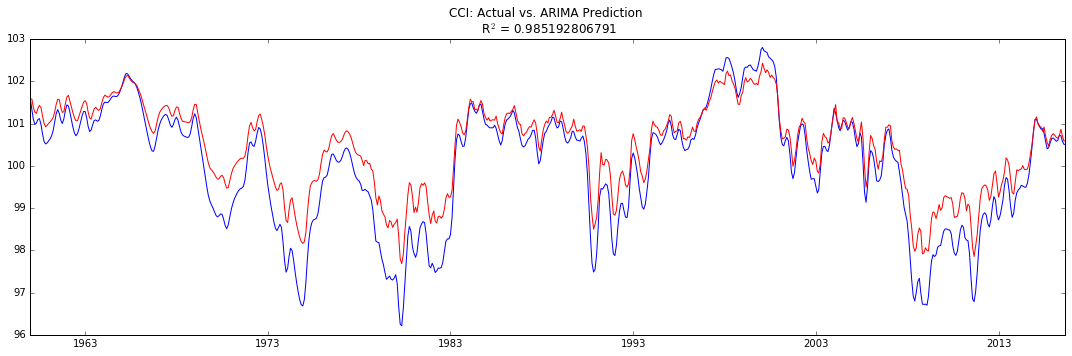

In [281]:
plt.figure(figsize = (15,5))
plt.plot(df)
plt.plot(pred, color = 'r')
plt.title('CCI: Actual vs. ARIMA Prediction \n R$^2$ = {}'.format(a))
plt.tight_layout()
plt.show()

- Seems pretty good.
- Relevant questions:
    - Is the R2 score the one we should 'outperform' with the inclusion of sentiment data? 
        - From the Stock paper, he mentioned some out of sample prediction error, trying to predict the next datapoint with the model parameters calculated with the previous observations, starting on a minimum time span. 
    - How to include exogenous regressors (Contemporaneous and lagged) in an ARIMA-statsmodel setting?
- We could use this same approach to test any time series, as long as we can automatically detect p and q from the acf and pacf. We could try this for other variables of interest, or the filtered outputs produced below from the execution of the HP or other time series filters. 

## Decompositions

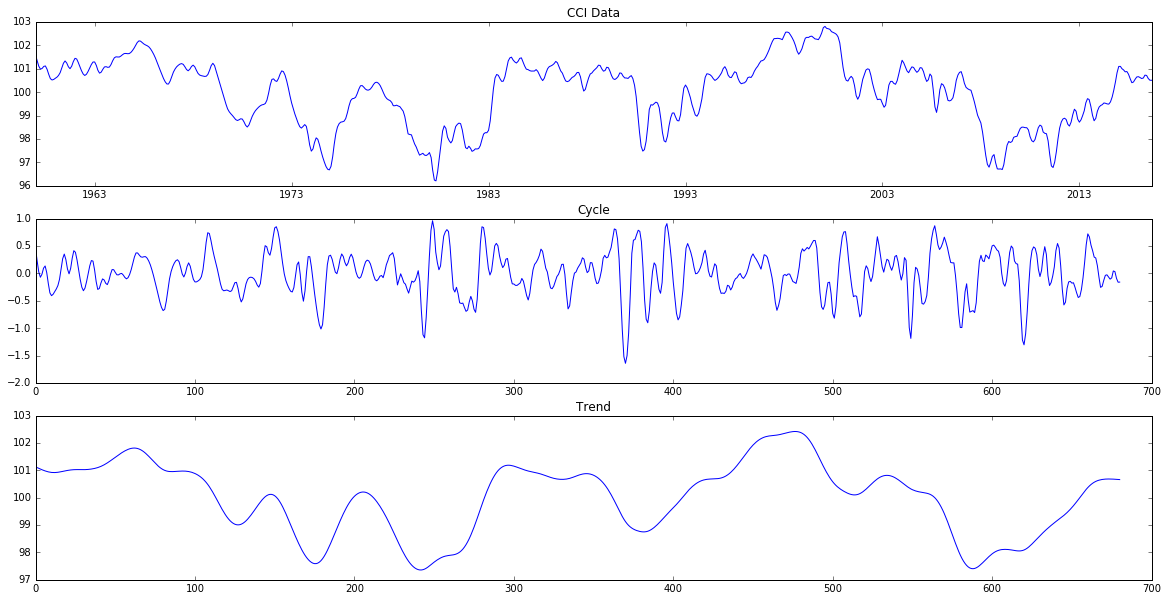

In [258]:

a, b = tsa.filters.hpfilter(df.values)
fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].plot(df)
ax[0].set_title("CCI Data")
ax[1].plot(a)
ax[1].set_title("Cycle")
ax[2].plot(b)
ax[2].set_title("Trend")
plt.show()